In [1]:
!pip install -U datasets

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 KB 4.7 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 17.7 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:000m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.8/219.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.9/333.9 KB 8.0 MB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.3/287.3 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.6/206.6 KB 3.9 MB/s eta 0:00:00m eta 0:00:01


In [1]:
import torch
import torch.nn.functional as F

from datasets import load_dataset

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

In [3]:
labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)}
itol = {i: l for l, i in ltoi.items()}

In [4]:
from transformers import AutoTokenizer

model_checkpoint = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract" # Or deberta-v3-large, etc.
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Check if the tokenizer is a fast tokenizer (it should be for DeBERTa-v3)
assert tokenizer.is_fast, "Only fast tokenizers are supported for this example."

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

In [5]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True, # Crucial for pre-tokenized input
        max_length=512,
        padding="max_length"

    )

    labels = []
    for i, label_sequence in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None: # Special tokens ([CLS], [SEP])
                label_ids.append(-100)
            elif word_idx != previous_word_idx: # First token of a new word
                label_ids.append(ltoi[label_sequence[word_idx]])
            else: # Subsequent tokens of the same word
                label_ids.append(-100)


            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [6]:
t = tokenizer(["Pakistan got nuked lmao"])
print(t.input_ids)
print(t.word_ids(0))

[[1, 4146, 519, 58917, 407, 107679, 2]]
[None, 0, 1, 2, 2, 3, None]


In [6]:
data = dataset.map(tokenize_and_align_labels, batched = True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [7]:
train_data, train_labels, train_attention_mask = data['train']['input_ids'], data['train']['labels'], data['train']['attention_mask']
val_data, val_labels, val_attention_mask = data['validation']['input_ids'], data['validation']['labels'], data['validation']['attention_mask']
test_data, test_labels, test_attention_mask = data['test']['input_ids'], data['test']['labels'], data['test']['attention_mask']

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 8

def get_batch(split = "train"):
  data = train_data if split == "train" else val_data
  labels = train_labels if split == "train" else val_labels
  attention_mask = train_attention_mask if split == "train" else val_attention_mask
  ix = torch.randint(len(data), (batch_size,))
  x = torch.stack([torch.tensor(data[i]).long() for i in ix])
  y = torch.stack([torch.tensor(labels[i]).long() for i in ix])
  a = torch.stack([torch.tensor(attention_mask[i]) for i in ix])
  return x.to(device), y.to(device), a.to(device)


@torch.no_grad()
def estimate_loss(eval_steps):
  out = {}
  model.eval()
  for split in ["train", "validation"]:
    losses = torch.zeros(eval_steps)
    for k in range(eval_steps):
      x, y, a = get_batch(split)
      logits = model(x, attention_mask = a).logits
      loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
      losses[k] = loss.item()
    out[split] = losses.mean()
  model.train()
  return out

In [9]:
torch.set_float32_matmul_precision("high")

In [10]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=n_labels,
    id2label=itol,
    label2id=ltoi
).to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model = torch.compile(model)

In [18]:
lre =torch.linspace(-6, -4, 1000)
lrs = 10**lre
print(lrs)

tensor([1.0000e-06, 1.0046e-06, 1.0093e-06, 1.0139e-06, 1.0186e-06, 1.0233e-06,
        1.0280e-06, 1.0328e-06, 1.0376e-06, 1.0424e-06, 1.0472e-06, 1.0520e-06,
        1.0569e-06, 1.0618e-06, 1.0667e-06, 1.0716e-06, 1.0765e-06, 1.0815e-06,
        1.0865e-06, 1.0915e-06, 1.0966e-06, 1.1016e-06, 1.1067e-06, 1.1119e-06,
        1.1170e-06, 1.1221e-06, 1.1273e-06, 1.1325e-06, 1.1378e-06, 1.1430e-06,
        1.1483e-06, 1.1536e-06, 1.1589e-06, 1.1643e-06, 1.1697e-06, 1.1751e-06,
        1.1805e-06, 1.1860e-06, 1.1915e-06, 1.1970e-06, 1.2025e-06, 1.2080e-06,
        1.2136e-06, 1.2192e-06, 1.2249e-06, 1.2305e-06, 1.2362e-06, 1.2419e-06,
        1.2477e-06, 1.2534e-06, 1.2592e-06, 1.2650e-06, 1.2709e-06, 1.2768e-06,
        1.2826e-06, 1.2886e-06, 1.2945e-06, 1.3005e-06, 1.3065e-06, 1.3126e-06,
        1.3186e-06, 1.3247e-06, 1.3308e-06, 1.3370e-06, 1.3432e-06, 1.3494e-06,
        1.3556e-06, 1.3619e-06, 1.3682e-06, 1.3745e-06, 1.3808e-06, 1.3872e-06,
        1.3936e-06, 1.4001e-06, 1.4065e-

In [12]:
from tqdm import tqdm

optim = torch.optim.AdamW(model.parameters(), lr = 3e-5)
max_steps = 1000

In [13]:
lossi = []
lri = []

for step in tqdm(range(max_steps)):
  # for g in optim.param_groups:
  #   g['lr'] = lrs[step]

  x, y, a = get_batch("train")
  optim.zero_grad()
  with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
    logits = model(x, attention_mask = a).logits
    loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1))
  loss.backward()
  optim.step()
  # lri.append(lre[step])
  # lossi.append(loss.item())
  if step % 100 == 0:
    losses = estimate_loss(200)
    print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['validation']:.4f}")


  0%|          | 1/1000 [00:36<10:13:46, 36.86s/it]

step 0: train loss 1.8617, val loss 1.8741


 10%|█         | 103/1000 [01:17<50:36,  3.39s/it]  

step 100: train loss 0.1638, val loss 0.2421


 20%|██        | 203/1000 [01:48<45:42,  3.44s/it]  

step 200: train loss 0.1701, val loss 0.2437


 30%|███       | 303/1000 [02:19<40:12,  3.46s/it]  

step 300: train loss 0.1289, val loss 0.2315


 40%|████      | 403/1000 [02:50<34:31,  3.47s/it]  

step 400: train loss 0.1132, val loss 0.2309


 50%|█████     | 503/1000 [03:22<28:49,  3.48s/it]

step 500: train loss 0.1007, val loss 0.2348


 60%|██████    | 603/1000 [03:53<23:02,  3.48s/it]

step 600: train loss 0.0836, val loss 0.2710


 70%|███████   | 703/1000 [04:25<17:14,  3.48s/it]

step 700: train loss 0.0817, val loss 0.3079


 80%|████████  | 803/1000 [04:56<11:26,  3.48s/it]

step 800: train loss 0.0643, val loss 0.2518


 90%|█████████ | 903/1000 [05:27<05:37,  3.48s/it]

step 900: train loss 0.0532, val loss 0.2718


100%|██████████| 1000/1000 [05:38<00:00,  2.96it/s]


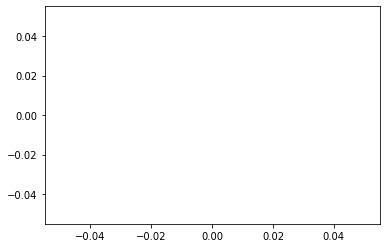

In [21]:
import matplotlib.pyplot as plt

plt.plot(lri, lossi)

In [14]:
from seqeval.metrics import f1_score, recall_score, precision_score, classification_report

In [15]:
@torch.no_grad()
def evaluate_model(split="test"):
    """Evaluate model performance on given split with seqeval metrics"""
    model.eval()
    
    if split == "test":
        data_input_ids = test_data
        data_labels = test_labels
        data_attention_mask = test_attention_mask
    elif split == "validation":
        data_input_ids = val_data
        data_labels = val_labels
        data_attention_mask = val_attention_mask
    else:
        data_input_ids = train_data
        data_labels = train_labels
        data_attention_mask = train_attention_mask
    
    # Process in smaller batches to avoid OOM
    batch_size_eval = 16
    all_true_labels = []
    all_pred_labels = []
    
    # Process the entire dataset
    for i in tqdm(range(0, len(data_input_ids), batch_size_eval), desc=f"Evaluating on {split}"):
        # Get batch
        batch_input_ids = torch.tensor(data_input_ids[i:i+batch_size_eval]).to(device)
        batch_labels = torch.tensor(data_labels[i:i+batch_size_eval]).to(device)
        batch_attention_mask = torch.tensor(data_attention_mask[i:i+batch_size_eval]).to(device)
        
        # Get predictions
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        # Convert predictions and labels to lists for seqeval
        for j in range(len(batch_input_ids)):
            true_label_ids = batch_labels[j].cpu().numpy()
            pred_label_ids = predictions[j].cpu().numpy()
            
            # Convert IDs to labels, handling special tokens
            true_seq = []
            pred_seq = []
            
            for true_id, pred_id, mask in zip(true_label_ids, pred_label_ids, batch_attention_mask[j]):
                if mask == 1 and true_id != -100:  # Only evaluate on non-padding and non-special tokens
                    true_seq.append(itol[true_id.item()])
                    pred_seq.append(itol[pred_id.item()])
            
            if true_seq:  # Only add if not empty
                all_true_labels.append(true_seq)
                all_pred_labels.append(pred_seq)
    
    # Calculate metrics using seqeval
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    report = classification_report(all_true_labels, all_pred_labels)
    
    print(f"\n=== Evaluation on {split} split ===")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nDetailed Classification Report:")
    print(report)
    
    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "report": report
    }

In [16]:
out = evaluate_model()

Evaluating on test: 100%|██████████| 16/16 [00:08<00:00,  1.97it/s]


=== Evaluation on test split ===
F1 Score: 0.8542
Precision: 0.8262
Recall: 0.8843

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.88      0.90      0.89       797
          LF       0.74      0.85      0.80       482

   micro avg       0.83      0.88      0.85      1279
   macro avg       0.81      0.88      0.84      1279
weighted avg       0.83      0.88      0.86      1279



In [25]:
evaluate_model('val')

Evaluating on val: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]



=== Evaluation on val split ===
F1 Score: 0.9306
Precision: 0.9024
Recall: 0.9606

Detailed Classification Report:
              precision    recall  f1-score   support

          AC       0.92      0.97      0.94      6626
          LF       0.88      0.95      0.91      3923

   micro avg       0.90      0.96      0.93     10549
   macro avg       0.90      0.96      0.93     10549
weighted avg       0.90      0.96      0.93     10549



{'f1': 0.93057213701901,
 'precision': 0.9023955828657939,
 'recall': 0.9605649824627926,
 'report': '              precision    recall  f1-score   support\n\n          AC       0.92      0.97      0.94      6626\n          LF       0.88      0.95      0.91      3923\n\n   micro avg       0.90      0.96      0.93     10549\n   macro avg       0.90      0.96      0.93     10549\nweighted avg       0.90      0.96      0.93     10549\n'}